In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from scipy import sparse
from scipy.sparse import coo_matrix
from scipy.sparse import coo_array
from scipy.sparse import identity

### Recommendations
- coo_array appears only in scipy version 1.8.0

In [50]:
def real_time_solver(psi0, dt, tmax, H, Q):
        """
        The discription is in developing
        Parameters
        ----------
            psi0: numpy.array
                    Initial state vector
                    
              dt: number
                   Time step
                    
            tmax: number
                   Time interval
                    
               H: 
                Hamiltonian of the system
                
                    1) scipy sparse matrix 
                        When Hamiltonian is constant
                    
                    2) time dependant function, which returns scipy sparse matrix
                        When Hamiltonian is time related
                    
               Q: 
                   1) scipy sparse matrix
                       Observable operators
                   2) a list of scipy sparse matrices
                       ?
                    
        Returns
        -------
         results: np.array or a list of np.arrays
                Average of observables
           
        """    
        K = psi0.size
        Nt = int(tmax/dt)+1
        psi = [psi0, psi0]
        
        if callable(H) == False:
            H_const = H
            def H(t):
                return(H_const)
         
        if type(Q) == list:
            l = len(Q)
            results= np.zeros((l,Nt))
            for j in range(l):
                results[j,0] = abs(np.conj(psi0) @ Q[j] @ psi0)
            
            for i in range(1,Nt):
                
                psi_iter_old = psi0
                psi_iter = np.zeros(K)
                psi_compare = psi0
                while (LA.norm(psi_iter-psi_compare)>10**(-6)):
                    s = psi[1]+psi_iter_old
                    psi_iter = psi[1]+ dt/2*(-1j) * H(i*dt+dt/2)@s
                    psi_compare = psi_iter_old
                    psi_iter_old = psi_iter
                psi[1] = psi_iter
                
                for j in range(l):
                    results[j,i] = abs(np.conj(psi[1]) @ Q[j] @ psi[1])
            
        else:
            results = np.zeros(Nt)
            results[0] = abs(np.conj(psi0) @ Q @ psi0)
            
            for i in range(1,Nt):
                psi_iter_old = psi0
                psi_iter = np.zeros(K)
                psi_compare = psi0
                while (LA.norm(psi_iter-psi_compare)>10**(-6)):
                    s = psi[1]+psi_iter_old
                    psi_iter = psi[1]+ dt/2*(-1j) * H(i*dt+dt/2)@s
                    psi_compare = psi_iter_old
                    psi_iter_old = psi_iter
                psi[1] = psi_iter
                results[i] = abs(np.conj(psi[1]) @ Q @ psi[1])
        
        return(results)
    
        

In [37]:
class fock_space:
    def __init__(self, about_excitations, global_exc, statistics):
        """The main elements anf functions of the Fock space:
        
        Parameters
        ----------
        about_excitations: int
                            Number of modes
        
                        or array like
                             Array of maximum numbers of local excitations on each site
                           
                            
               global_exc: int
                            Global limiNt on the total number of excitations
                
                statistics: 'Bose' or 'Fermi'
                             Establishes the statistics of the Fock space. 
                            
        Returns
        -------
        1) self.modes: int
            A number of modes
            
        2) self.local_exc: numpy.array
            An array of maximum numbers of local excitations on each site  
            
        3) self.states_list: list of tuples
            A list of all the possible states
            
        4) self.find_index: dict
            A dictionary for translating a state tuple to a state index
            
        5) self.states_numb: int
            A number of all posible states
            
        6) self.emptyH: scipy sparse matrix
            A sparse matrix for hamiltonian
            
        7) self.eye: scipy sparse matrix
            An idenitiy operator
        
        8) self annihilate: scipy sparse matrix
            A list of annihilation operators for each mode(from 0 to self.modes-1)
            
        9) self create: scipy sparse matrix
            A list of creation operators for each mode(from 0 to self.modes-1)
            
        """
        self.global_exc = global_exc #internal parameter
        self.statistics = statistics #internal parameter
            
        if statistics == 'Bose':
            
            if type(about_excitations) is int:
        #1)
                self.modes = about_excitations
        #2)
                self.local_exc = np.full(self.modes, global_exc)
            else:
        #1)
                self.modes = len(about_excitations)
        #2)
                self.local_exc = np.array(about_excitations)
        
        elif statistics == 'Fermi':
            if type(about_excitations) is int:
        #1)
                self.modes = about_excitations
        #2)
                self.local_exc = np.full(self.modes, 1)
            else:
        #1)
                self.modes = len(about_excitations)
        #2)
                self.local_exc = np.array(about_excitations)
                
        else:
            print('Сhoose the statistics: Bose or Fermi') 
        
        self.local_exc1 = np.array(self.local_exc+1) #internal parameter
        
        #3)
        self.states_list = list(self.states_generator())
        
        #4)
        self.find_index = {state: idx for idx, state in enumerate(self.states_list)}
        
        #5)
        self.states_numb = len(self.states_list)
        
        #6)
        self.emptyH = coo_matrix((self.states_numb, self.states_numb), dtype = complex)
        
        #7)
        self.eye = sparse.eye(self.states_numb)
        
        
        if statistics == 'Bose':
            
        #8)    
            self.annihilate=[]
            current_state = []
            for k in range(self.modes):
                row = np.zeros(self.states_numb)
                col = np.arange(self.states_numb, dtype=int)
                data = np.zeros(self.states_numb)
                for i in range(self.states_numb):
                    if self.states_list[i][k]==0:
                        row[i] = i
                    else:
                        current_state = list(self.states_list[i])
                        current_state[k]-=1
                        p = self.index(current_state)
                        row[i] = p
                        data[i]=(self.states_list[i][k])**0.5
                A = coo_matrix((data, (row, col)), shape=(self.states_numb, self.states_numb), dtype = complex)
                self.annihilate.append(A) 
                
            
        #9)
            self.create=[]
            current_state = []
            for k in range(self.modes):
                row = np.zeros(self.states_numb)
                col = np.arange(self.states_numb, dtype=int)
                data = np.zeros(self.states_numb)
                for i in range(self.states_numb):
                    if self.states_list[i][k] == self.local_exc[k] or sum(self.states_list[i]) == self.global_exc:#!!!!!!!!!!!!!!!!!!!!!!
                        row[i] = i 
                    else:
                        current_state = list(self.states_list[i])
                        current_state[k]+=1
                        p = self.index(current_state)
                        row[i] = p
                        data[i]=(self.states_list[i][k]+1)**0.5
                A = coo_matrix((data, (row, col)), shape=(self.states_numb, self.states_numb), dtype = complex)
                self.create.append(A)
       
        elif statistics == 'Fermi':
        
        #8)
            self.annihilate=[]
            current_state = []
            for k in range(self.modes):
                row = np.zeros(self.states_numb)
                col = np.arange(self.states_numb, dtype=int)
                data = np.zeros(self.states_numb)
                for i in range(self.states_numb):
                    if self.states_list[i][k]==0:
                        row[i] = i
                    else:
                        current_state = list(self.states_list[i])
                        y = sum(current_state[:k])
                        current_state[k] = 0
                        p = self.index(current_state)
                        row[i] = p
                        data[i]=(-1)**y*(self.states_list[i][k])**0.5
                A = coo_matrix((data, (row, col)), shape=(self.states_numb, self.states_numb), dtype = complex)
                self.annihilate.append(A)
                              
         #9)       
            self.create=[]
            current_state = []
            for k in range(self.modes):
                row = np.zeros(self.states_numb)
                col = np.arange(self.states_numb, dtype=int)
                data = np.zeros(self.states_numb)
                for i in range(self.states_numb):
                    if self.states_list[i][k] == self.local_exc[k] or sum(self.states_list[i]) == self.global_exc:
                        row[i] = i 
                    else:
                        current_state = list(self.states_list[i])
                        y = sum(current_state[:k])
                        current_state[k] = 1
                        p = self.index(current_state)
                        row[i] = p
                        data[i]=(-1)**y*(self.states_list[i][k]+1)**0.5
                A = coo_matrix((data, (row, col)), shape=(self.states_numb, self.states_numb), dtype = complex)
                self.create.append(A)
            
        else:
            print('Сhoose the statistics: Bose or Fermi')
                  
                
    def sigmax(self, i):
        """
        A Pauli operator for i-th mode 

        Parameters
        ----------
            i: int
                An index of the mode                                          
                            
        Returns
        -------
            sparse matrix
        """
        return(self.annihilate[i] + self.create[i])
    
    
    def sigmay(self, i):
        """
        A Pauli operator for i-th mode 

        Parameters
        ----------
            i: int
                An index of the mode                         
                                                  
        Returns
        -------
            sparse matrix
        """
        return(1j*(-self.annihilate[i] + self.create[i]))
    
    
    def sigmaz(self, i):
        """
        A Pauli operator for i-th mode 

        Parameters
        ----------
            i: int
                An index of the mode                                         
                            
        Returns
        -------
            sparse matrix
        """
        return(self.annihilate[i]@self.create[i] - self.create[i]@self.annihilate[i])
  
        
    def states_generator(self):
        #Generates all the possible states for given Fock space
        current_state = (0,)*len(self.local_exc1)
        n = 0
        while True:
            yield current_state
            j = len(self.local_exc1) - 1
            current_state = current_state[:j] + (current_state[j]+1,)
            n += 1
            while n > self.global_exc or current_state[j] >= self.local_exc1[j]:
                j -= 1
                if j < 0:
                    return
                n -= current_state[j+1] - 1
                current_state = current_state[:j] + (current_state[j]+1, 0) + current_state[j+2:]
            
        
    def occupations(self,i):
        """
        Parameters
        ----------
            i: int
                An index of the state
        
        Returns
        -------
        state: tuple
            A tuple of state for given index
        """
        
        if i >= self.states_numb:
            print('the number is out of range')
        else:
            return(self.states_list[i])
    
    
    def index(self, state):
        """
        Parameters
        ----------
            state: tuple, list or array like
                Fock state of the given Fock space
        
        Returns
        -------
            i: int
                An index of the state
        """
        
        if len(state) != self.modes:
            print('incorrect size of an array')
        else:
            s = tuple(state)
            return(self.find_index[s])
    


        
class fock_space_kron:
    def __init__(self, f1, f2):
        """The Kronecker product of two Fock spaces
        
        Parameters
        ----------
        f1, f2: fock_space class
                      
        Returns
        -------
        1) self.modes: int
            A number of modes
          
        2) self.states_numb: int
            A number of all posible states
            
        3) self.emptyH: scipy sparse matrix
            A sparse matrix for hamiltonian
            
        4) self.eye: scipy sparse matrix
            An idenitiy operator
        
        5) self annihilate: scipy sparse matrix
            A list of annihilation operators for each mode(from 0 to self.modes-1)
            
        6) self create: scipy sparse matrix
            A list of creation operators for each mode(from 0 to self.modes-1)
        """
        #1)
        self.modes = f1.modes + f2.modes

        #2)
        self.states_numb = f1.states_numb * f2.states_numb

        #3)
        self.emptyH = coo_matrix((self.states_numb, self.states_numb), dtype = complex)

        #4)
        self.eye = sparse.eye(self.states_numb)
       
        
        if (f1.statistics=='Fermi') and (f2.statistics=='Fermi'):
            from scipy.sparse import diags
            
            data1 = np.zeros(f1.states_numb)
            data2 = np.zeros(f2.states_numb)
            
            for i in range(f1.states_numb):
                k = sum(f1.occupations(i))
                data1[i] = (-1)**k
            for i in range(f2.states_numb):
                k = sum(f2.occupations(i))
                data2[i] = (-1)**k
        
        #4.1)
            self.parity_f1 = diags(data1)
        #4.2)
            self.parity_f2 = diags(data2)
        
        #5)
            self.annihilate=[]
        
            for k in range(f1.modes):
                self.annihilate.append(sparse.kron(f1.annihilate[k], self.parity_f1))
            for k in range(f1.modes, self.modes):
                self.annihilate.append(sparse.kron(self.parity_f2, f2.annihilate[k-f1.modes]))
        #6)
            self.create=[]
        
            for k in range(f1.modes):
                self.create.append(sparse.kron(f1.create[k], f2.eye))
            for k in range(f1.modes, self.modes):
                self.create.append(sparse.kron(f1.eye, f2.create[k-f1.modes]))
        
        else:
            
        #5)
            self.annihilate=[]
        
            for k in range(f1.modes):
                self.annihilate.append(sparse.kron(f1.annihilate[k], f2.eye))
            for k in range(f1.modes, self.modes):
                self.annihilate.append(sparse.kron(f1.eye, f2.annihilate[k-f1.modes]))
        #6)
            self.create=[]
        
            for k in range(f1.modes):
                self.create.append(sparse.kron(f1.create[k], f2.eye))
            for k in range(f1.modes, self.modes):
                self.create.append(sparse.kron(f1.eye, f2.create[k-f1.modes]))
            
    def sigmax(self, i):
        """
        A Pauli operator for i-th mode 

        Parameters
        ----------
            i: int
                An index of the mode                                          
                            
        Returns
        -------
            sparse matrix
        """
        if (i<f1.modes):
             return(sparse.kron(f1.sigmax(i), f2.eye))
        else:
            return(sparse.kron(f1.eye, f2.sigmax(i-f1.modes)))

        
    def sigmay(self, i):
        """
        A Pauli operator for i-th mode 

        Parameters
        ----------
            i: int
                An index of the mode                                                 
                            
        Returns
        -------
            sparse matrix
        """
        if (i<f1.modes):
             return(sparse.kron(f1.sigmay(i), f2.eye))
        else:
            return(sparse.kron(f1.eye, f2.sigmay(i-f1.modes)))

        
    def sigmaz(self, i):
        """
        A Pauli operator for i-th mode 

        Parameters
        ----------
            i: int
                An index of the mode                         
                                                   
        Returns
        -------
            sparse matrix
        """
        if (i<f1.modes):
             return(sparse.kron(f1.sigmaz(i), f2.eye))
        else:
            return(sparse.kron(f1.eye, f2.sigmaz(i-f1.modes)))
    
    
    def occupations(self,i):
        """
        Parameters
        ----------
            i: int
                An index of the state
        
        Returns
        -------
        state: tuple
            A tuple of state for given index
        """
        
        if i >= self.states_numb:
            print('the number is out of range')
        else:
            state = np.zeros(self.modes, dtype = int)
            state[:f1.modes] = f1.occupations(i//f2.states_numb)
            state[f1.modes:] = f2.occupations(i%f2.states_numb)
            return(tuple(state))
        
        
    def index(self,state):
        """
        Parameters
        ----------
            state: tuple, list or array like
                A Fock state from the kronecker product of gives Fock spaces
        
        Returns
        -------
            i: int
                An index of the state
        """
        
        if state.size != self.modes:
            print('incorrect size of an array')
        else:
            s = list(state)
            return(f1.index(state[:f1.modes]) * f2.states_numb + f2.index(state[f1.modes:]))


# Usage example

In [41]:
%%time
f1 = fock_space(1,1, statistics = 'Bose')
f2 = fock_space(7,14, statistics = 'Bose')
f = fock_space_kron(f1,f2)


CPU times: total: 1.84 s
Wall time: 1.84 s


### Problem parameters

In [42]:
Es = 1
Eps = 1
h = 0.05
U = 0

K = f.states_numb
m = f.modes
a = f.annihilate
a_dag = f.create


psi0 = np.zeros(f.states_numb, dtype = complex)
j1 = 0
psi0[j1]=1


dt = 0.01
tmax = 10

### Hamiltonian building

In [43]:
H0 = f.emptyH
def func(t):
    return(0.1*np.cos(t))


H0 += Es*a_dag[0]@a[0] + h*a_dag[0]@a[1] + h*a[0]@a_dag[1]
for i in range(1,m-1):
    H0 += Eps*a_dag[i]@a[i] + U*a_dag[i]@a[i]@(a_dag[i]@a[i] - f.eye) + h * a_dag[i+1]@a[i] + h * a_dag[i]@a[i+1]
    
def H(t):
    return (H0 + f.sigmax(0)*func(t))

In [31]:
H(34).size

2480625

### Evolve the system

In [51]:
%%time
Q = a_dag[0]@a[0]
occupation_of_qubit = real_time_solver(psi0, dt, tmax, H, Q)

CPU times: total: 14min 29s
Wall time: 3min 37s


### Visualize the results

C:\Users\mrsgm\AppData\Local\Temp\ipykernel_14008\3025138999.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


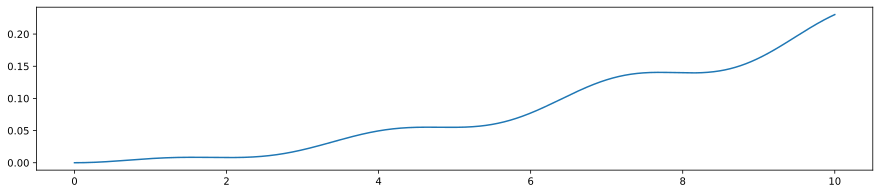

In [53]:
from numpy import loadtxt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')


t=np.linspace(0,tmax,int(tmax/dt)+1)
plt.figure(figsize=(15,3))
#plt.grid()

plt.plot(t, occupation_of_qubit)

#plt.savefig('fock_clss_result3.svg')